# Drug Classification(EDA & ML Classification)

## 1. Dataset Description
There are 6 variables in the dataset:
- Age
- Sex
- BP(Blood Pressure Levels)
- Cholesterol
- Sodium to Potassium Ratio
- Drug Type(Target)

## 2. Imports and Dataset Exploration

In [2]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style = 'darkgrid')

In [3]:
# df import
df = pd.read_csv(r"C:\Users\egeeb\Python\Datasets\drug200.csv")

In [4]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

As it can be seen; the dataset has no empty cells, therefore it does not require any operations the drop empty columns or cleaning.
A function called 'Plotter' will be created to plot each variables' density plot. It will take the dataframe as an input; create a list out of its column names; then plot the density plots 

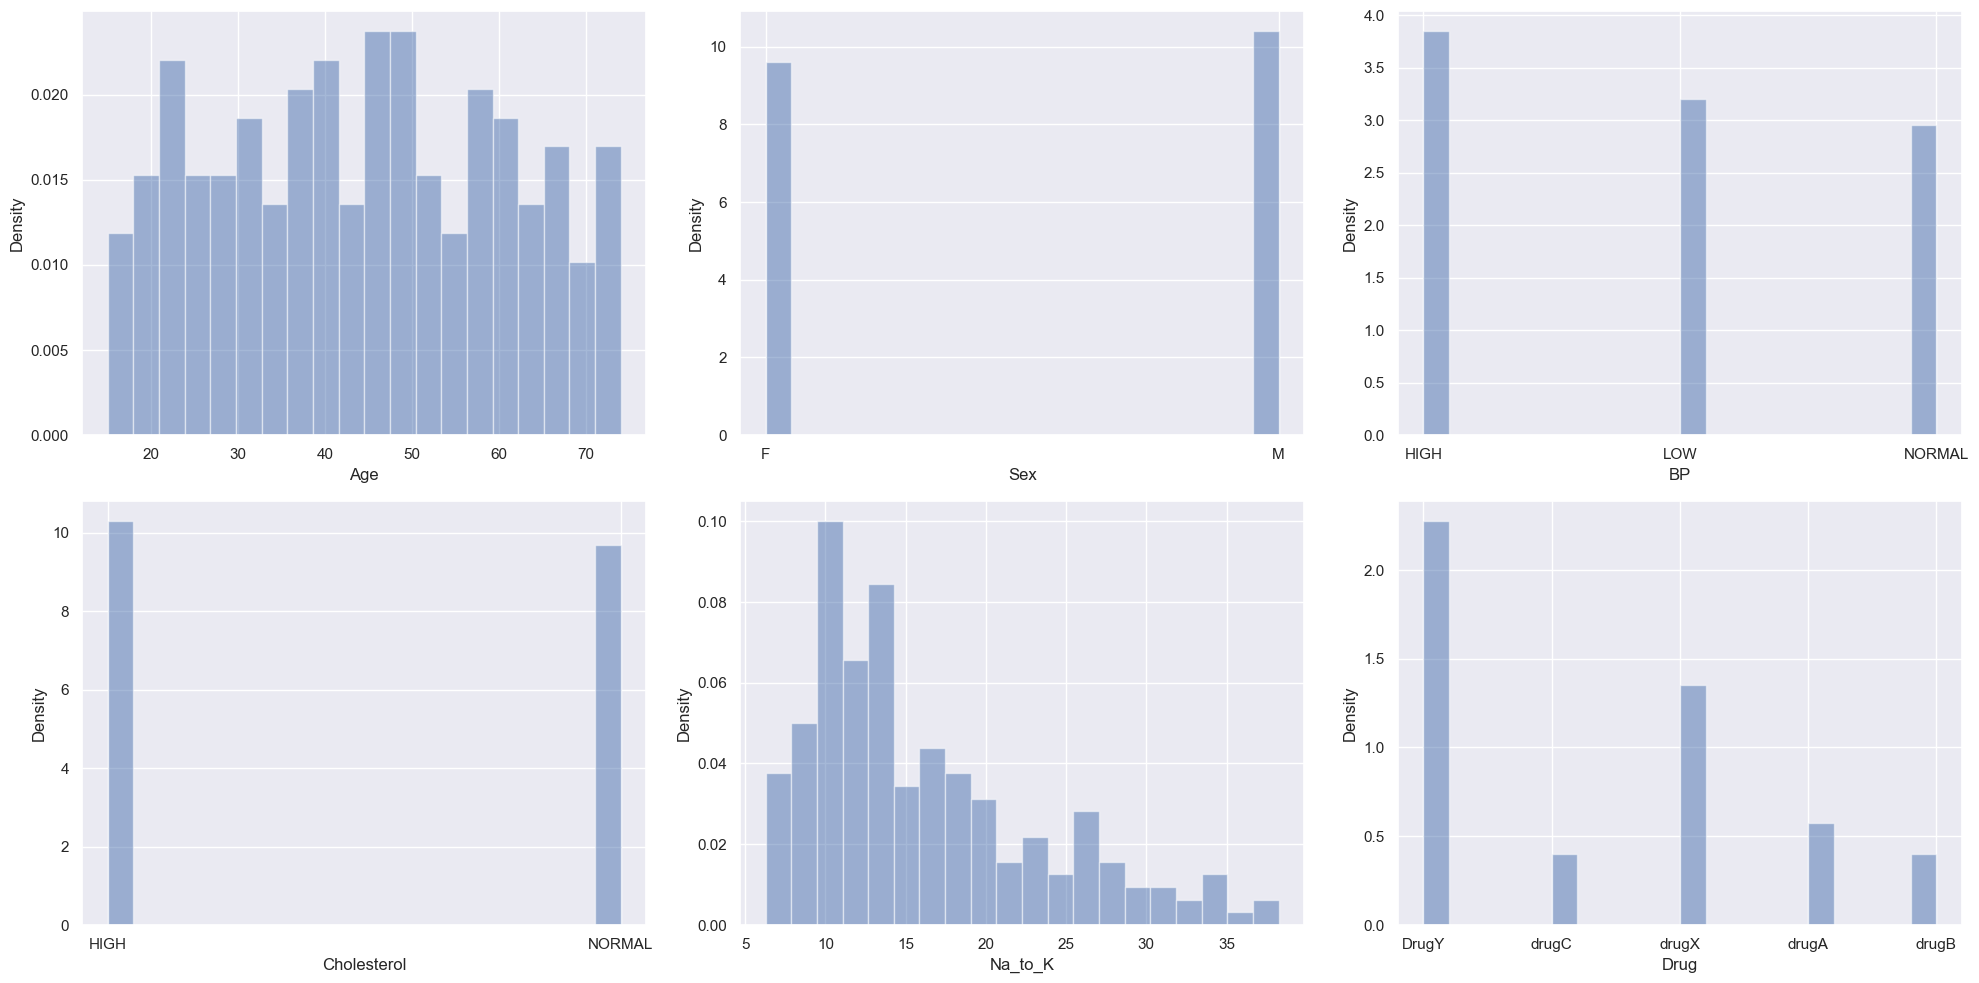

In [5]:
def density_plotter(df):
    variable_names = list(df.columns)
    number_of_plots = len(variable_names)
    number_of_rows = (number_of_plots + 2) // 3
    fig, axs = plt.subplots(number_of_rows, 3, figsize = (20, 10))
    
    # Plotting
    for i, variable_name in enumerate(variable_names):
        row = i // 3 #Can be only 0 and 1 since index starts from 0 and ends at 5
        col = i % 3 # Can only be [0, 1, 2].
        axs[row, col].hist(df[variable_name], bins = 20, density = True, alpha = 0.5)
        axs[row, col].set_xlabel(variable_name)
        axs[row, col].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

density_plotter(df)

- "Age" variable is symetrically distributed.
- "Gender" variable is evenly distributed between Male and Female.
- "Cholesterol" variable is evenly distributed between High and Low.
- "Na_to_K" variable is slightly skewed.


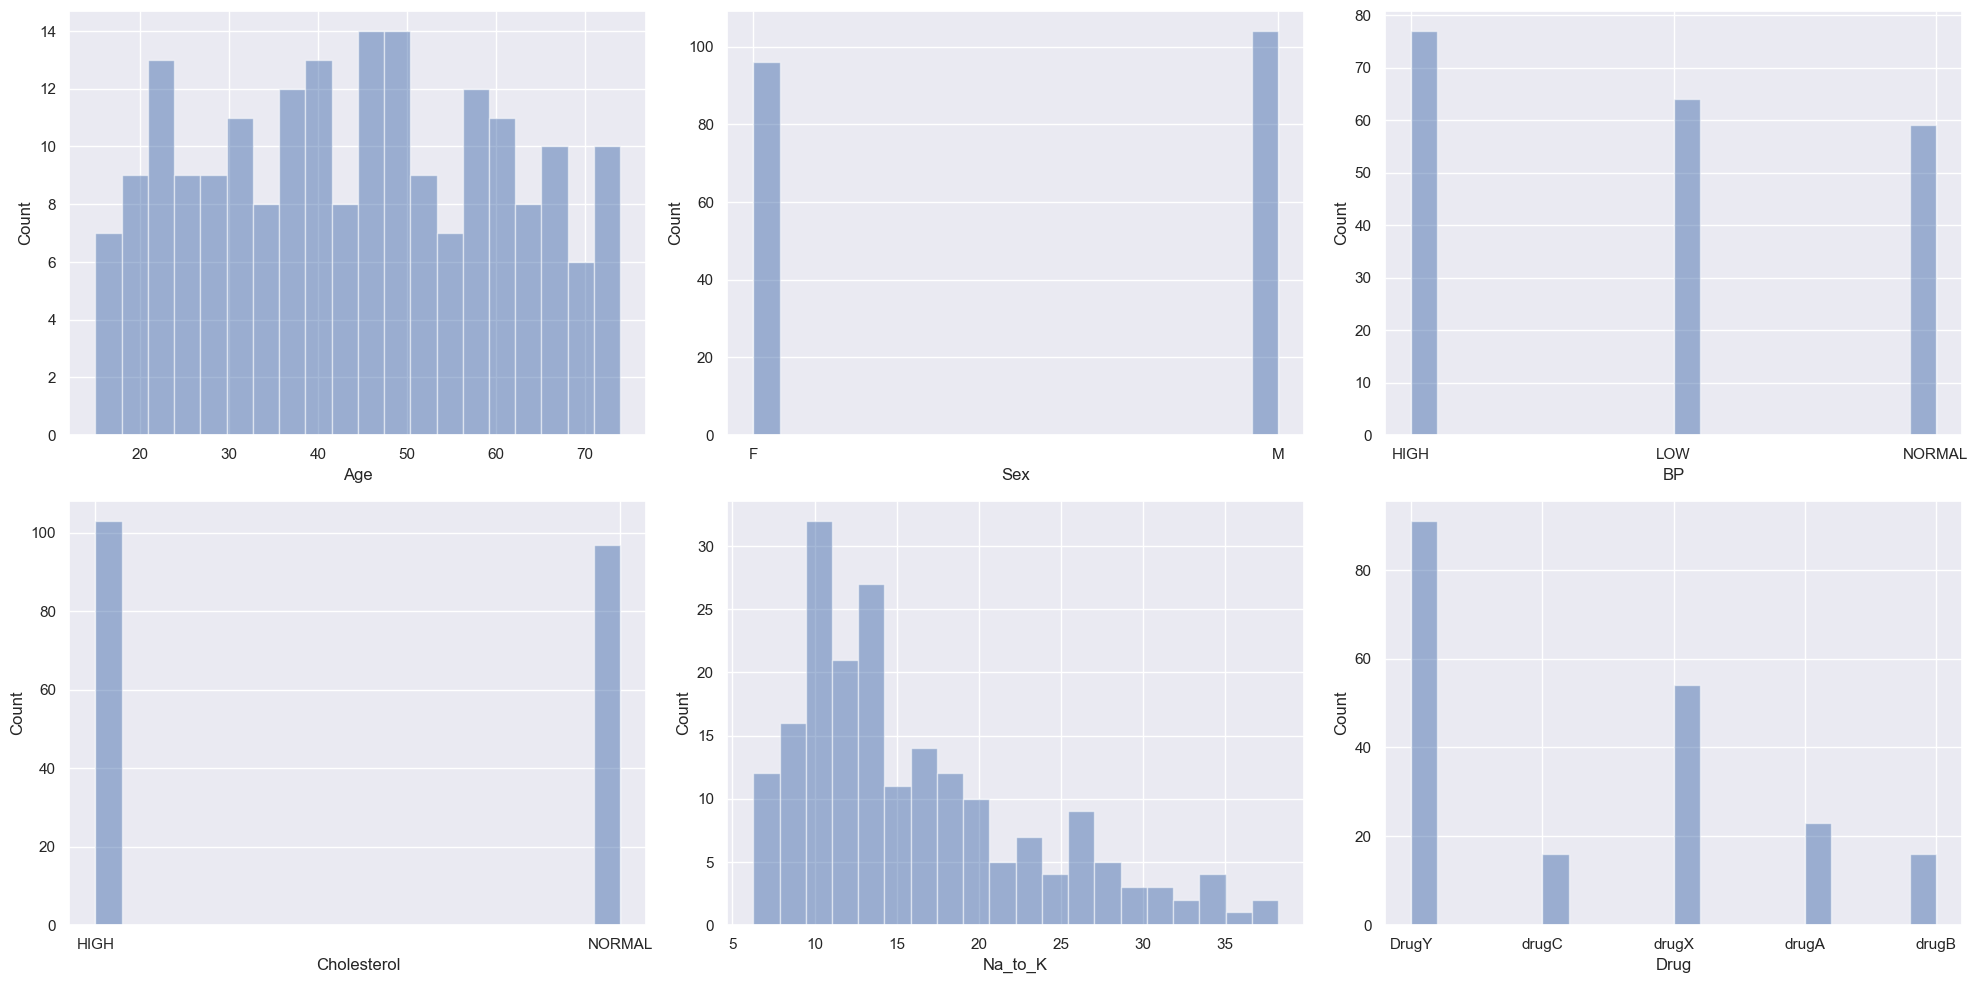

In [6]:
def count_plotter(df):
    variable_names = list(df.columns)
    number_of_plots = len(variable_names)
    number_of_rows = (number_of_plots + 2) // 3
    fig, axs = plt.subplots(number_of_rows, 3, figsize = (20, 10))
    
    # Plotting
    for i, variable_name in enumerate(variable_names):
        row = i // 3 #Can be only 0 and 1 since index starts from 0 and ends at 5
        col = i % 3 # Can only be [0, 1, 2].
        axs[row, col].hist(df[variable_name], bins = 20, alpha = 0.5)
        axs[row, col].set_xlabel(variable_name)
        axs[row, col].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

count_plotter(df)

"Age" and "Na_to_K" variables have to be grouped for better data analysis.
Age will be grouped as:
- Under 25
- 25-35
- 35-45
- 45-55
- 55-65
- Over 65

Na_to_K will be grouped as:
- Under 5
- 5-15
- 15-25
- 25-35
- Over 35

In [7]:
age_grouped = []
na_to_k_grouped = []
for i in df['Na_to_K']:
    if i <= 5:
        na_to_k_grouped.append('0-5')
    elif i > 5 and i <= 15:
        na_to_k_grouped.append('5-15')
    elif i > 15 and i <= 25:
        na_to_k_grouped.append('15-25')
    elif i > 25 and i <= 35:
        na_to_k_grouped.append('25-35')
    else:
        na_to_k_grouped.append('35+')
        
for i in df['Age']:
    if i <= 25:
        age_grouped.append('0-25')
    elif i > 25 and i <= 35:
        age_grouped.append('25-35')
    elif i > 35 and i <= 45:
        age_grouped.append('35-45')
    elif i > 45 and i <= 55:
        age_grouped.append('45-55')
    elif i > 55 and i <= 65:
        age_grouped.append('55-65')
    else:
        age_grouped.append('65+')
        
df['Age_Grouped'] = age_grouped
df["Na_to_K_Grouped"] = na_to_k_grouped
df.head()


,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Age_Grouped,Na_to_K_Grouped
0,23,F,HIGH,HIGH,25.355,DrugY,0-25,25-35
1,47,M,LOW,HIGH,13.093,drugC,45-55,5-15
2,47,M,LOW,HIGH,10.114,drugC,45-55,5-15
3,28,F,NORMAL,HIGH,7.798,drugX,25-35,5-15
4,61,F,LOW,HIGH,18.043,DrugY,55-65,15-25


<Axes: xlabel='Age_Grouped', ylabel='count'>

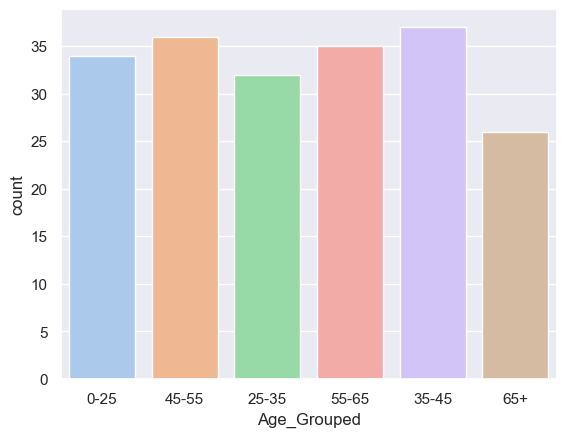

In [11]:
sns.countplot(x = 'Age_Grouped', data = df, palette = 'pastel')

<Axes: xlabel='Na_to_K_Grouped', ylabel='count'>

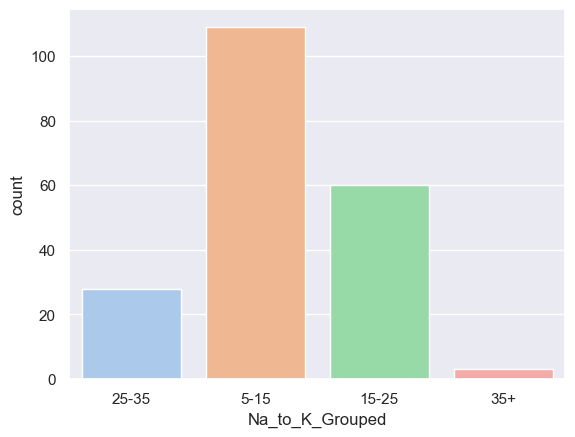

In [9]:
sns.countplot(x = 'Na_to_K_Grouped', data = df, palette = 'pastel')

<Axes: xlabel='Drug', ylabel='count'>

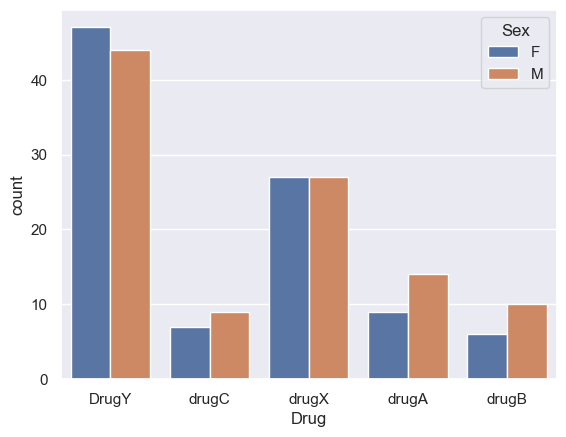

In [12]:
sns.countplot(x = df['Drug'], hue = "Sex", data = df)

<Axes: xlabel='Drug', ylabel='count'>

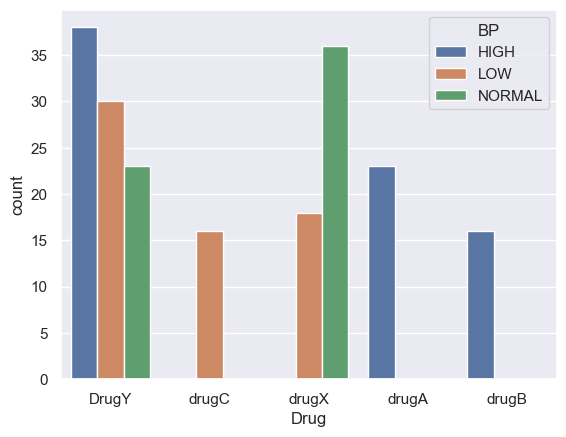

In [13]:
sns.countplot(x = df['Drug'], hue = "BP", data = df)

<Axes: xlabel='Drug', ylabel='count'>

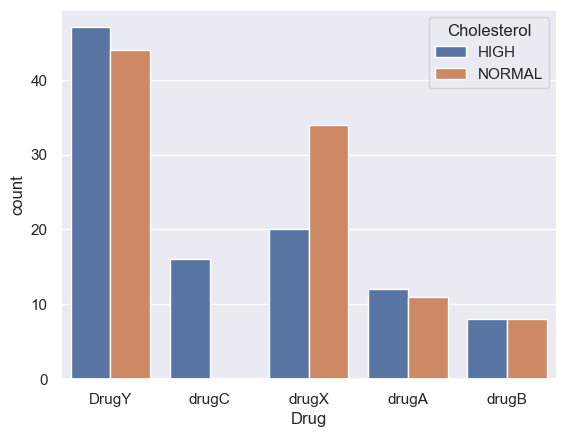

In [14]:
sns.countplot(x = df['Drug'], hue = "Cholesterol", data = df)

Text(0, 0.5, 'Drug Type')

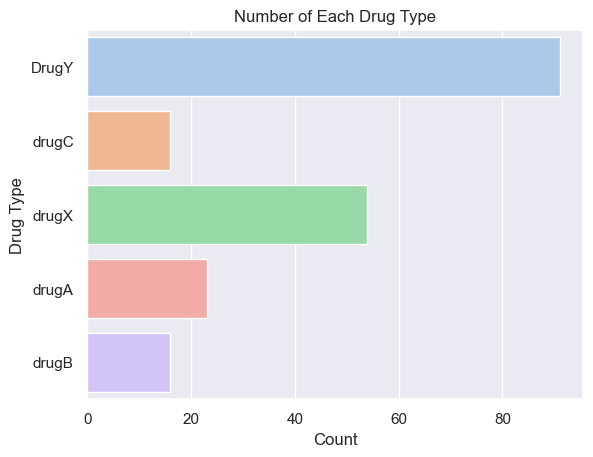

In [15]:
sns.countplot(y = 'Drug', data = df, palette = 'pastel')
plt.title('Number of Each Drug Type')
plt.xlabel('Count')
plt.ylabel("Drug Type")

As it can be seen from the figure above, the drug type "DrugY" dominates the dataset. To avoid overfitting; an oversampling technique called SMOTE(Synthetic Minority Oversampling Technique) will be used to oversample other drug types.

In [16]:
# Some insights from the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Sex              200 non-null    object 
 2   BP               200 non-null    object 
 3   Cholesterol      200 non-null    object 
 4   Na_to_K          200 non-null    float64
 5   Drug             200 non-null    object 
 6   Age_Grouped      200 non-null    object 
 7   Na_to_K_Grouped  200 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 12.6+ KB


As it can be seen from the info snippet above; there are multiple variables with object data type. The objects will be processed with "labelencoder" from the "sklearn.preprocessing" library.

## 3. Data Preprocessing and SMOTE(Synthetic Minority Oversampling Technique)

The grouped data is not needed for the machine learning algorithms, they were only implemented to show the data distribution. Therefore two columns called "Age_Grouped" and "Na_to_K_Grouped" will be dropped.

In [17]:
df = df.drop(["Age_Grouped", "Na_to_K_Grouped"], axis = 1)

In [18]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
for i in list(df.columns):
    if df[i].dtype == 'object':
        df[i] = LabelEncoder().fit_transform(df[i])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int32  
 2   BP           200 non-null    int32  
 3   Cholesterol  200 non-null    int32  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    int32  
dtypes: float64(1), int32(4), int64(1)
memory usage: 6.4 KB


Now all variables have the datatype of 'int64', which makes every variable usable in the classification algorithms to be implemented.

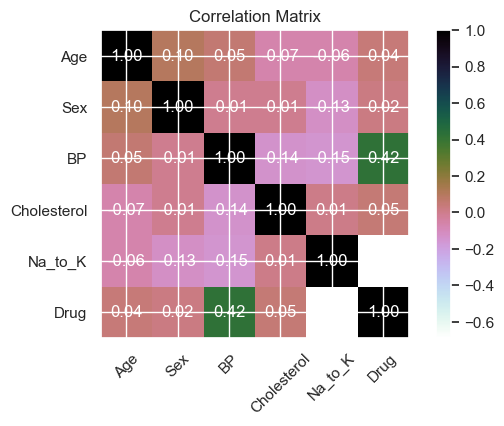

In [22]:
correlation_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(7, 4))

# Create a heatmap
heatmap = plt.imshow(correlation_matrix, cmap = 'cubehelix_r', interpolation='nearest')

# Display the correlation values on the heatmap
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='w')

# Set labels and title
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Correlation Matrix")

# Display the colorbar
plt.colorbar(heatmap)

# Show the plot
plt.show()

"Blood Pressure" variable has the highest correlation with Drug type.

## 4. Implementation of ML Algorithms

First, a function to extract features and target will be created. From previous analysis, the target has been identified as "Drug".

In [23]:
def train_evaluate(df, features, label, model_list):
    """
    Train and evaluate machine learning models for a given list of algorithms.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the dataset
    - features (list): List of feature names
    - label (String): The label
    - model_list (list): List of machine learning algorithms (pre-instantiated models)

    Returns:
    - results_df (pd.DataFrame): DataFrame containing algorithm names and corresponding accuracy scores
    """
    results = []
    
    X = df.drop(["Drug"], axis = 1)
    y = df['Drug']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    
    for algorithm in model_list:
        model = algorithm
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        accuracy = accuracy_score(prediction, y_test)
        results.append({'Algorithm': algorithm.__class__.__name__, 'Accuracy %': accuracy * 100})

    results_df = pd.DataFrame(results)
    return results_df

In [24]:
label = "Drug"
model_list = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), LogisticRegression()]
features = list(df.columns)
features.remove(label)
train_evaluate(df, features, label, model_list)

,Algorithm,Accuracy %
0,KNeighborsClassifier,72.0
1,DecisionTreeClassifier,100.0
2,RandomForestClassifier,100.0
3,SVC,82.0
4,LogisticRegression,82.0


## 5. Hyperparameter Optimization

In [25]:
def feature_extractor(df, label):
    features = list(df.columns)
    features.remove(label)
    return features


In [26]:
knn_params = {"n_neighbors": range(2, 50)}

decision_tree_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [5, 20, None],
             "max_features": [3, 10, "auto"],
             "min_samples_split": [10, 20],
             "n_estimators": [150, 300]}

svc_params = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'gamma': ['scale', 'auto', 0.1, 1, 10],}

lr_params = {'penalty': ['l1', 'l2'],
             'C': [0.001, 0.01, 0.1, 1, 10, 100],
             'solver': ['liblinear', 'lbfgs'],}

classifiers = [(KNeighborsClassifier(), knn_params),
               (DecisionTreeClassifier(), decision_tree_params),
               (RandomForestClassifier(), rf_params),
               (SVC(), svc_params),
               (LogisticRegression(), lr_params)]

In [27]:
def hyperparameter_opti(df, features, label, model_list):
    """
    Train and evaluate machine learning models for a given list of algorithms.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the dataset
    - features (list): List of feature names
    - label (String): The label
    - model_list (list): List of machine learning algorithms (pre-instantiated models)

    Returns:
    - results_df (pd.DataFrame): DataFrame containing algorithm names and corresponding accuracy scores
    """
    results = []
    
    X = df[features]
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    for algorithm, params in model_list:
        # Perform GridSearchCV for hyperparameter tuning
        gs_best = GridSearchCV(algorithm, params, cv=5, n_jobs=-1, verbose=False).fit(X_train, y_train)
        final_model = algorithm.set_params(**gs_best.best_params_)
        
        # Fit the final model on the entire training set
        final_model.fit(X_train, y_train)
        
        # Evaluate the model using cross-validation
        cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='accuracy')
        mean_cv_accuracy = np.mean(cv_scores)
        
        # Make predictions on the test set
        prediction = final_model.predict(X_test)
        
        # Calculate accuracy and add results to the list
        accuracy = accuracy_score(prediction, y_test)
        results.append({'Algorithm': algorithm.__class__.__name__, 'Accuracy': accuracy, 'Mean CV Accuracy': mean_cv_accuracy})
        
        # Print accuracy score
        print(f'{algorithm.__class__.__name__} Accuracy score: {accuracy * 100}%')
        print(f'{algorithm.__class__.__name__} Mean Cross-Validation Accuracy: {mean_cv_accuracy * 100}%\n')
    
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

In [28]:
def main():
    model_list = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), LogisticRegression()]
    label = "Drug"
    features = feature_extractor(df, label)
    print(f'The features are: {features}')
    first_results = train_evaluate(df, features, label, model_list)
    print(f'First results are: {first_results}')
    print(f"After Hyperparameter Optimization:")
    post_optimization = hyperparameter_opti(df, features, label, classifiers)
    print("Ended.")

if __name__ == "__main__":
    print("End to End")
    main()

End to End
The features are: ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']
First results are:                 Algorithm  Accuracy %
0    KNeighborsClassifier        72.0
1  DecisionTreeClassifier       100.0
2  RandomForestClassifier       100.0
3                     SVC        82.0
4      LogisticRegression        82.0
After Hyperparameter Optimization:
KNeighborsClassifier Accuracy score: 74.0%
KNeighborsClassifier Mean Cross-Validation Accuracy: 70.0%

DecisionTreeClassifier Accuracy score: 100.0%
DecisionTreeClassifier Mean Cross-Validation Accuracy: 98.66666666666667%

RandomForestClassifier Accuracy score: 100.0%
RandomForestClassifier Mean Cross-Validation Accuracy: 98.66666666666667%

SVC Accuracy score: 100.0%
SVC Mean Cross-Validation Accuracy: 98.00000000000001%

LogisticRegression Accuracy score: 96.0%
LogisticRegression Mean Cross-Validation Accuracy: 95.33333333333334%

                Algorithm  Accuracy  Mean CV Accuracy
0    KNeighborsClassifier      0.74          0.7

## 6. Conclusion
The evaluation results of various machine learning algorithms on the dataset are presented here. The models were assessed based on both their accuracy on a holdout test set and their mean cross-validation accuracy, providing a more robust estimation of generalization performance.

KNeighborsClassifier:
Achieved a test set accuracy of 74% and a mean cross-validation accuracy of 70%. This model demonstrated moderate performance on the test set with consistent results across cross-validation folds.

DecisionTreeClassifier:
Attained a perfect test set accuracy of 100% and a mean cross-validation accuracy of 98.67%. While the DecisionTreeClassifier exhibited perfect accuracy on the test set, suggesting potential overfitting, the high cross-validation accuracy indicates strong generalizability.

RandomForestClassifier:
Achieved a perfect test set accuracy of 100% and a mean cross-validation accuracy of 98.67%. Similar to the DecisionTreeClassifier, the RandomForestClassifier demonstrated perfect accuracy on the test set and strong performance in cross-validation.

SVC (Support Vector Classifier):
Demonstrated excellent performance with a test set accuracy of 100% and a mean cross-validation accuracy of 98%. The Support Vector Classifier exhibited high accuracy on the test set and robust performance in cross-validation.

LogisticRegression:
Obtained a test set accuracy of 96% and a mean cross-validation accuracy of 95.33%. The LogisticRegression model achieved high accuracy on the test set and consistent performance in cross-validation, indicating a well-generalized model.

To enhance the models' performance, hyperparameter optimization was conducted using GridSearchCV. The resulting models showed improved or maintained accuracy levels, highlighting the effectiveness of fine-tuning model parameters.

In summary, the DecisionTreeClassifier, RandomForestClassifier, SVC, and LogisticRegression models exhibited strong performance on the dataset, with high accuracy and generalization capability. Consideration of other metrics and further investigation into model interpretability can provide additional insights into the models' behavior. The choice of the final model may depend on the specific requirements of the application, such as the importance of interpretability, computational efficiency, or the nature of the data.